In [96]:
import pystac
import pystac_client
import stackstac
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import hvplot.xarray
from dask.distributed import Client
import rioxarray
import os
import matplotlib.pyplot as plt
import ulmo
from datetime import datetime
import xarray as xr
import rioxarray as rxr
import warnings

In [2]:
# MODIFY PARAMETERS

#-------------------------------------------------------------------------
# comment ONE of these out at a time
#relative_orbit_number = 137 # change to get any particular relative orbit
#orbit_direction = 'ascending' # 'ascending', descending', 'all'
orbit_direction = 'all'
#-------------------------------------------------------------------------
# define time slice
today = datetime.today().strftime('%Y-%m-%d')
#time_slice = slice('2019-10-01','2020-09-30') # All of 2020 water year
time_slice = slice('2015-01-01',today) # All of 2020

#time_slice = slice('2017-01-01',today)
#-------------------------------------------------------------------------
polarization ='gamma0_vv'
#-------------------------------------------------------------------------
bounding_box_gf = gpd.read_file('shapefiles/mt_rainier.geojson')
#-------------------------------------------------------------------------
rainier_glaciers = gpd.read_file('shapefiles/rainier_glaciers.geojson')
#-------------------------------------------------------------------------
#-------------------------------------------------------------------------
cloud_cover_threshold = 20
#resample_freq_s1 = "W" # https://towardsdatascience.com/resample-function-of-pandas-79b17ec82a78
resample_freq_s2 = "2W"
#resample_freq = "MS"
shapefile_clip = True

In [3]:
#plt.style.use('seaborn-poster')


In [4]:
if 'relative_orbit_number' in locals():
    by_orbit = True
else: 
    by_orbit = False

In [5]:
# GDAL environment variables for better performance
os.environ['AWS_REGION']='us-west-2'
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
os.environ['AWS_NO_SIGN_REQUEST']='YES' 

In [6]:
# Paste /proxy/localhost:8787 for cluster diagnostics
client = Client(local_directory='/tmp', processes=False)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.25.45.79:8787/status,
Dashboard: http://172.25.45.79:8787/status,Workers: 1
Total threads: 32,Total memory: 125.71 GiB
Status: running,Using processes: False
Comm: inproc://172.25.45.79/293864/1,Workers: 1
Dashboard: http://172.25.45.79:8787/status,Total threads: 32
Started: Just now,Total memory: 125.71 GiB
Comm: inproc://172.25.45.79/293864/4,Total threads: 32
Dashboard: http://172.25.45.79:35721/status,Memory: 125.71 GiB
Nanny: None,


In [7]:
xr.set_options(keep_attrs=True)

In [8]:
# Load STAC ItemCollection
stac_items = pystac.ItemCollection.from_file('mycollection.json')
items = [item.to_dict(transform_hrefs=False) for item in stac_items]

stack = stackstac.stack(items,
                        dtype='float32')
stack

,Array,Chunk
Bytes,128.67 GiB,4.00 MiB
Shape,"(382, 3, 5490, 5490)","(1, 1, 1024, 1024)"
Count,43584 Tasks,41256 Chunks
Type,float32,numpy.ndarray


In [9]:
# import bounding box
bounding_box_utm_gf = bounding_box_gf.to_crs(stack.crs)
xmin, ymax, xmax, ymin = bounding_box_utm_gf.bounds.values[0]

In [10]:
# filter scenes
scenes = stack.sel(band=polarization).sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)

In [11]:
# filter by orbit direction or orbit number
if by_orbit:
    scenes = scenes.where(scenes.coords['sat:relative_orbit']==relative_orbit_number,drop=True)
    orbit_directions = scenes.coords['sat:orbit_state']
    orbit_direction = orbit_directions[0].values
elif orbit_direction == 'all':
    scenes = scenes
else:
    scenes = scenes.where(scenes.coords['sat:orbit_state']==orbit_direction,drop=True)

In [12]:
scenes

<xarray.DataArray 'stackstac-7781853c534c6db3ed926857ea02f61d' (time: 382, y: 861, x: 889)>
dask.array<getitem, shape=(382, 861, 889), dtype=float32, chunksize=(1, 861, 829), chunktype=numpy.ndarray>
Coordinates:
  * time                         (time) datetime64[ns] 2017-01-01T02:09:52 .....
    id                           (time) <U22 'S1A_20170101_10TES_ASC' ... 'S1...
    band                         <U9 'gamma0_vv'
  * x                            (x) float64 5.858e+05 5.858e+05 ... 6.036e+05
  * y                            (y) float64 5.2e+06 5.2e+06 ... 5.183e+06
    proj:epsg                    int64 32610
    sar:looks_range              int64 5
    sar:resolution_azimuth       float64 22.6
    mgrs:grid_square             <U2 'ES'
    end_datetime                 (time) <U20 '2017-01-01T02:10:07Z' ... '2021...
    sar:instrument_mode          <U2 'IW'
    sat:orbit_state              (time) <U10 'ascending' ... 'ascending'
    instruments                  <U5 'c-sar'
    created                      (time) <U27 '2021-11-29T19:15:01.133965Z' .....
    sar:pixel_spacing_range      int64 10
    sat:absolute_orbit           (time) int64 14632 3663 3736 ... 26566 26588
    sar:looks_azimuth            int64 1
    constellation                <U10 'sentinel-1'
    start_datetime               (time) <U20 '2017-01-01T02:09:38Z' ... '2021...
    sentinel:product_ids         (time) object ['S1A_IW_GRDH_1SDV_20170101T02...
    sar:center_frequency         float64 5.405
    mgrs:latitude_band           <U1 'T'
    sar:polarizations            object {'VH', 'VV'}
    proj:shape                   object {5490}
    sar:looks_equivalent_number  float64 4.3
    sar:product_type             <U3 'RTC'
    sar:frequency_band           <U1 'C'
    sar:observation_direction    <U5 'right'
    proj:transform               object {0.0, 1.0, -20.0, 499980.0, 5200020.0...
    sar:resolution_range         float64 20.3
    sat:relative_orbit           (time) int64 35 137 35 35 137 ... 64 13 115 137
    gsd                          int64 20
    sar:pixel_spacing_azimuth    int64 10
    mgrs:utm_zone                <U2 '10'
    platform                     (time) <U11 'sentinel-1a' ... 'sentinel-1b'
    sentinel:mgrs                <U5 '10TES'
    title                        <U21 'Gamma0 VV backscatter'
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(499980.0, 5090220.0, 609780.0...
    crs:         epsg:32610
    transform:   | 20.00, 0.00, 499980.00|\n| 0.00,-20.00, 5200020.00|\n| 0.0...
    resolution:  20.0

In [13]:
# could resample at the end in order to get more pixelwise values
if 'resample_freq_s1' in locals():
    scenes = scenes.resample(time=resample_freq_s1,restore_coord_dims=True).mean("time", keep_attrs=True)
#   resampled = lowcloud.resample(time=resample_freq).mean("time", keep_attrs=True)
else:
    scenes = scenes

In [14]:
%%time
# compute frames, drop missing data
frames_all = scenes.compute()
frames = frames_all.dropna('time',how='all')

CPU times: user 18.1 s, sys: 1.66 s, total: 19.8 s
Wall time: 13.9 s


In [15]:
mins_info = frames.argmin(dim='time',skipna=False)

In [16]:
lower_lon, upper_lat, upper_lon, lower_lat = bounding_box_gf.bounds.values[0]
lon = (lower_lon + upper_lon)/2
lat = (lower_lat + upper_lat)/2

In [17]:
URL = "https://earth-search.aws.element84.com/v0"
catalog = pystac_client.Client.open(URL)

In [18]:
items = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2020-01-01/2021-01-01"
).get_all_items()

In [19]:
stack = stackstac.stack(items)
xr.set_options(keep_attrs=True)
stack

,Array,Chunk
Bytes,8.49 TiB,8.00 MiB
Shape,"(298, 17, 20982, 10980)","(1, 1, 1024, 1024)"
Count,1180609 Tasks,1170246 Chunks
Type,float64,numpy.ndarray


In [20]:
# import bounding box
bounding_box_utm_gf = bounding_box_gf.to_crs(stack.crs)
xmin, ymax, xmax, ymin = bounding_box_utm_gf.bounds.values[0]
rainier_glaciers = rainier_glaciers.to_crs(stack.crs)

In [21]:
lowcloud = stack[stack["eo:cloud_cover"] < cloud_cover_threshold]
#stack.sel(time=time_slice) 298 images for the year
#lowcloud.sel(time=time_slice) 87 lowcloud days for the year

In [22]:
t = np.datetime64('2020-05-05T19:21:34.000000000')

In [23]:
lowcloud = lowcloud.loc[lowcloud.time !=t]

In [24]:
# could resample at the end in order to get more pixelwise values
if 'resample_freq_s2' in locals():
    lowcloud = lowcloud.resample(time=resample_freq_s2).median("time", keep_attrs=True)
#   resampled = lowcloud.resample(time=resample_freq).mean("time", keep_attrs=True)
else:
    lowcloud = lowcloud

/mnt/working/egagli/sw/miniconda3/envs/aws-rtc-stac2/lib/python3.8/site-packages/dask/array/core.py:4454: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/mnt/working/egagli/sw/miniconda3/envs/aws-rtc-stac2/lib/python3.8/site-packages/dask/array/core.py:4454: PerformanceWarning: Increasing number of chunks by factor of 21
  result = blockwise(
/mnt/working/egagli/sw/miniconda3/envs/aws-rtc-stac2/lib/python3.8/site-packages/dask/array/core.py:4454: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


In [25]:
nir, red, = lowcloud.sel(band="B08"), lowcloud.sel(band="B04")
ndvi = (nir-red)/(nir+red)

In [26]:
%%time
time_slice_ndvi = slice('2020-07-30','2020-09-09')
scenes_ndvi = ndvi.sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice_ndvi).mean("time", keep_attrs=True)
frames_ndvi_all = scenes_ndvi.compute()

CPU times: user 41.9 s, sys: 5.41 s, total: 47.3 s
Wall time: 17.6 s


In [27]:
frames_ndvi_all.values

array([[0.85194057, 0.85056406, 0.84872799, ..., 0.77201445, 0.62403421,
        0.68219083],
       [0.86133354, 0.8504887 , 0.84941285, ..., 0.83651044, 0.81767487,
        0.79855408],
       [0.86424338, 0.84712955, 0.85342417, ..., 0.83914115, 0.8491428 ,
        0.83542809],
       ...,
       [0.88559523, 0.87448092, 0.87949005, ..., 0.87123583, 0.86338851,
        0.84410924],
       [0.87335939, 0.87439301, 0.87588552, ..., 0.84898818, 0.86686516,
        0.86558988],
       [0.87883767, 0.88425514, 0.88143604, ..., 0.84249561, 0.85628414,
        0.86984011]])

In [28]:
frames_ndvi_all = frames_ndvi_all.rio.reproject_match(frames)

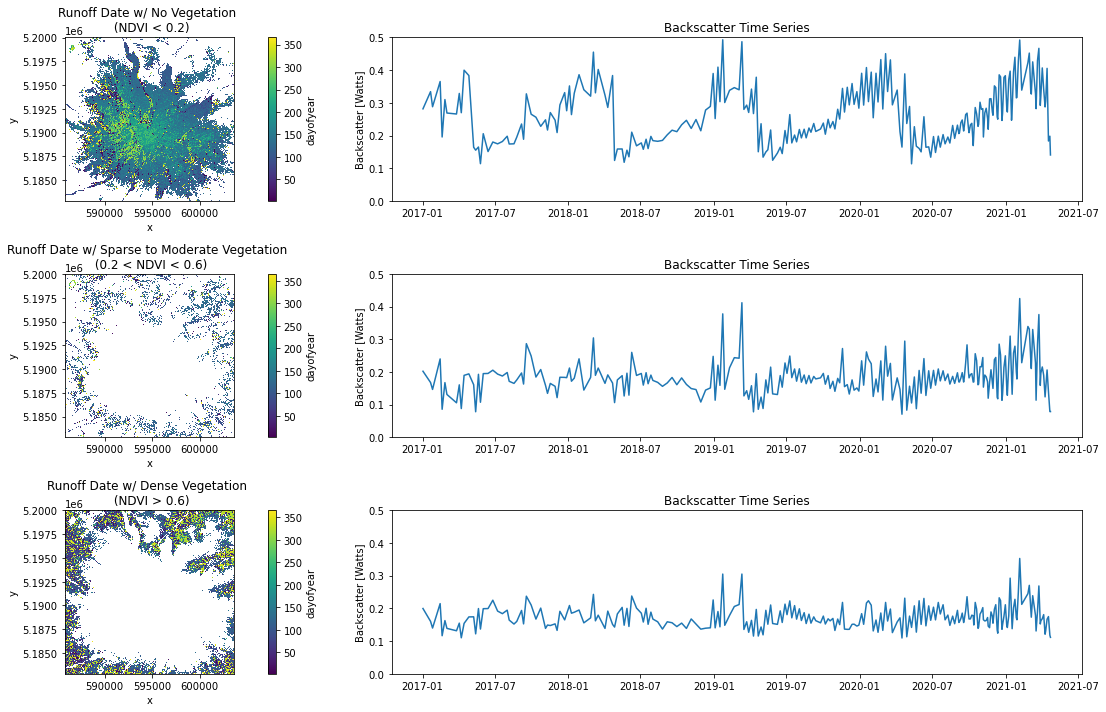

In [29]:
f,ax=plt.subplots(3,2,figsize=(20,10))
frames[mins_info].time.dt.dayofyear.where(frames_ndvi_all.values<0.2).plot(ax=ax[0,0])
ax[0,0].set_title('Runoff Date w/ No Vegetation \n (NDVI < 0.2)')
frames[mins_info].time.dt.dayofyear.where(frames_ndvi_all.values>0.2).where(frames_ndvi_all.values<0.6).plot(ax=ax[1,0])
ax[1,0].set_title('Runoff Date w/ Sparse to Moderate Vegetation \n (0.2 < NDVI < 0.6)')
#frames[mins_info].time.dt.dayofyear.where(frames_ndvi_all.values>0.4).where(frames_ndvi_all.values<0.6).plot(ax=ax[2,0])
#ax[2,0].set_title('Runoff Date w/ Moderate Vegetation \n (0.4 < NDVI < 0.6)')
frames[mins_info].time.dt.dayofyear.where(frames_ndvi_all.values>0.6).plot(ax=ax[2,0])
ax[2,0].set_title('Runoff Date w/ Dense Vegetation \n (NDVI > 0.6)')

ax[0,0].set_aspect('equal')
ax[1,0].set_aspect('equal')
ax[2,0].set_aspect('equal')


ax[0,1].plot(frames.where(frames_ndvi_all.values<0.2).time,frames.where(frames_ndvi_all.values<0.2).mean(dim=['x','y']))

ax[1,1].plot(frames.where(frames_ndvi_all.values>0.2).where(frames_ndvi_all.values<0.6).time,frames.where(frames_ndvi_all.values>0.2).where(frames_ndvi_all.values<0.6).mean(dim=['x','y']))

#ax[2,1].plot(frames.where(frames_ndvi_all.values>0.4).where(frames_ndvi_all.values<0.6).time,frames.where(frames_ndvi_all.values>0.4).where(frames_ndvi_all.values<0.6).mean(dim=['x','y']))

ax[2,1].plot(frames.where(frames_ndvi_all.values>0.6).time,frames.where(frames_ndvi_all.values>0.6).mean(dim=['x','y']))

ax[0,1].set_title('Backscatter Time Series')
ax[1,1].set_title('Backscatter Time Series')
ax[2,1].set_title('Backscatter Time Series')

ax[0,1].set_ylabel('Backscatter [Watts]')
ax[1,1].set_ylabel('Backscatter [Watts]')
ax[2,1].set_ylabel('Backscatter [Watts]')

ax[0,1].set_ylim([0,0.5])
ax[1,1].set_ylim([0,0.5])
ax[2,1].set_ylim([0,0.5])

plt.tight_layout()

In [30]:
# now plot time series means for all groups perhaps in a column to the right of each figure

/tmp/ipykernel_293864/1498834391.py:17: RuntimeWarning: Mean of empty slice
  backscatter_ts_for_bin = np.nanmean(frames_bin.data.reshape(frames_bin.shape[0],-1), axis=1) # (30,)


Text(0.5, 0.98, 'Mt. Rainier Sentinel-1 SAR Backscatter binned by Elevation \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each row: 2 week backscatter means for a given 100m elevation bin')

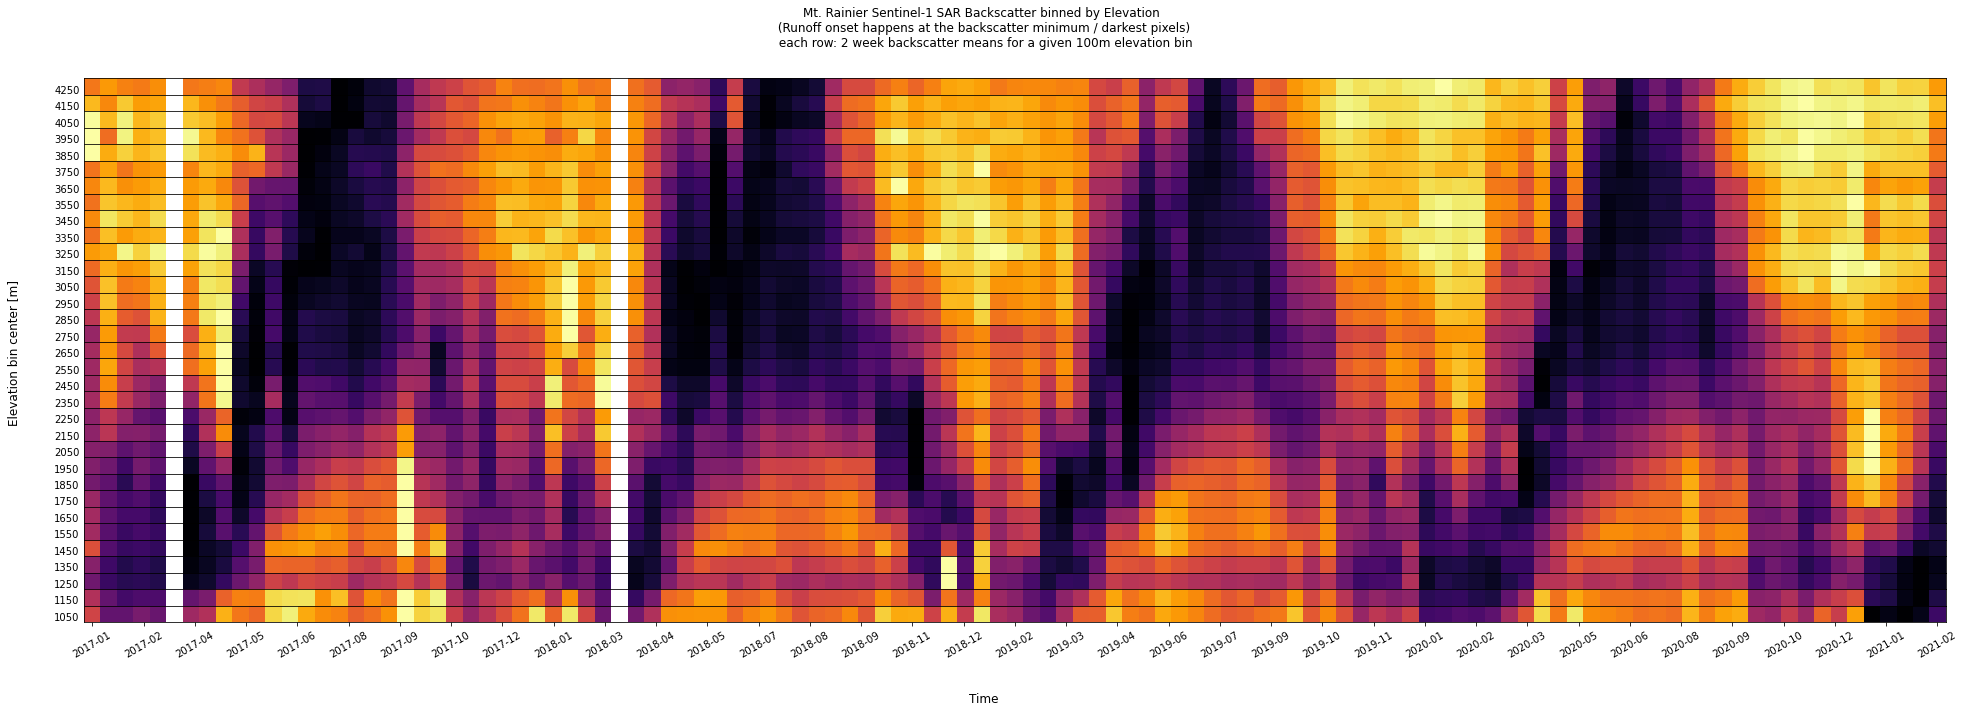

In [31]:
bin_size = 100
bin_centers = list(range(4250,1000,-100))

dem = rxr.open_rasterio('dem/dem_rainier_py3dep.tif',masked=True)
dem_projected = dem.rio.reproject_match(frames)
#dem_projected = dem_projected.rio.clip(rainier_glaciers.geometry,rainier_glaciers.crs,drop=False,invert=False) 

frames_elev = frames.where(frames_ndvi_all.values<0.2).resample(time='2W').mean(dim='time')
#month_labels = np.array(['J', 'F', 'M', 'A', 'M', 'J', 'J','A', 'S','O','N','D'])
#month_labels = np.array(['O','N','D','J', 'F', 'M', 'A', 'M', 'J', 'J','A', 'S'])

fig, ax = plt.subplots(len(bin_centers), figsize=(8*len(frames_elev)/26,10))
fig.subplots_adjust(hspace=0,wspace=0)

for idx,bin_center in enumerate(bin_centers):
    frames_bin = frames_elev.where(np.abs(dem_projected - bin_center) < bin_size//2)
    backscatter_ts_for_bin = np.nanmean(frames_bin.data.reshape(frames_bin.shape[0],-1), axis=1) # (30,)
    i = idx
    ax[i].imshow(backscatter_ts_for_bin.reshape(1,-1),cmap='inferno') #cool_r
    #ax[i].set_title(f"{bin_center-bin_size//2}-{bin_center+bin_size//2} m")
    ax[i].set_ylabel(f"{bin_center}",rotation='horizontal',loc='bottom',labelpad=30.0)
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    if i == 32:
        #ax[i].set_xticks(np.linspace(0,24,12), month_labels[0:12], rotation=0)
        #ax[i].set_xticks(np.linspace(0,24,12), rotation=0)
        datelabels=[pd.to_datetime(x).strftime('%Y-%m') for x in frames_elev.time.values[0::3]]
        del datelabels[-1]
        ax[i].set_xticks(np.linspace(0,len(frames_elev)-1,len(frames_elev)//3),datelabels, rotation=30)
        #ax[i].set_xlabel('Time')
fig.supxlabel("Time")
fig.supylabel("Elevation bin center [m]",x=0.11)
fig.suptitle("Mt. Rainier Sentinel-1 SAR Backscatter binned by Elevation \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each row: 2 week backscatter means for a given 100m elevation bin")

#plt.tight_layout()


In [32]:
int(dem.max())

4392

In [33]:
bin_size=100


In [34]:
list(range(int(math.ceil(dem.max()/100)*100)-bin_size//2,int(math.floor(dem.min()/100)*100),-bin_size))

[4350,
 4250,
 4150,
 4050,
 3950,
 3850,
 3750,
 3650,
 3550,
 3450,
 3350,
 3250,
 3150,
 3050,
 2950,
 2850,
 2750,
 2650,
 2550,
 2450,
 2350,
 2250,
 2150,
 2050,
 1950,
 1850,
 1750,
 1650,
 1550,
 1450,
 1350,
 1250,
 1150,
 1050,
 950,
 850]

In [35]:
# can try this instead https://matplotlib.org/stable/gallery/images_contours_and_fields/pcolormesh_levels.html#sphx-glr-gallery-images-contours-and-fields-pcolormesh-levels-py

In [36]:
def plot_timeseries_by_elevation_bin(ts_xr,dem_xr,bin_size=100,ax=None):
    dem_projected_xr = dem_xr.rio.reproject_match(ts_xr)
    dem_projected_xr=dem_projected_xr.where(ts_xr!=np.nan) # here mask DEM by ts_xr 
    
    bin_centers=list(range(int(math.floor(dem_projected_xr.max()/100)*100)-bin_size//2,int(math.ceil(dem_projected_xr.min()/100)*100),-bin_size))
    
    fig, ax = plt.subplots(len(bin_centers), figsize=(8*len(ts_xr)/26,10))
    fig.subplots_adjust(hspace=0,wspace=0)

    for i,bin_center in enumerate(bin_centers):
        ts_bin_xr = ts_xr.where(np.abs(dem_projected_xr - bin_center) < bin_size//2)
        backscatter_ts_for_bin = np.nanmean(ts_bin_xr.data.reshape(ts_bin_xr.shape[0],-1), axis=1) # (30,)
        ax[i].imshow(backscatter_ts_for_bin.reshape(1,-1),cmap='inferno',vmin=0,vmax=1) #cool_r
        ax[i].set_ylabel(f"{bin_center}",rotation='horizontal',loc='bottom',labelpad=30.0)
        ax[i].set_yticks([])
        ax[i].set_xticks([])
        if bin_center == bin_centers[-1]: #if last time in loop plot x label
            datelabels=[pd.to_datetime(x).strftime('%Y-%m') for x in ts_xr.time.values[0::3]]
            del datelabels[-1]
            ax[i].set_xticks(np.linspace(0,len(ts_xr)-1,len(ts_xr)//3),datelabels, rotation=30)
    fig.supxlabel("Time")
    fig.supylabel("Elevation bin center [m]",x=0.11)
    fig.suptitle("Mt. Rainier Sentinel-1 SAR Backscatter binned by Elevation \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each row: 2 week backscatter means for a given 100m elevation bin")

/tmp/ipykernel_293864/613704092.py:12: RuntimeWarning: Mean of empty slice
  backscatter_ts_for_bin = np.nanmean(ts_bin_xr.data.reshape(ts_bin_xr.shape[0],-1), axis=1) # (30,)
/tmp/ipykernel_293864/613704092.py:12: RuntimeWarning: Mean of empty slice
  backscatter_ts_for_bin = np.nanmean(ts_bin_xr.data.reshape(ts_bin_xr.shape[0],-1), axis=1) # (30,)
/tmp/ipykernel_293864/613704092.py:12: RuntimeWarning: Mean of empty slice
  backscatter_ts_for_bin = np.nanmean(ts_bin_xr.data.reshape(ts_bin_xr.shape[0],-1), axis=1) # (30,)
/tmp/ipykernel_293864/613704092.py:12: RuntimeWarning: Mean of empty slice
  backscatter_ts_for_bin = np.nanmean(ts_bin_xr.data.reshape(ts_bin_xr.shape[0],-1), axis=1) # (30,)
/tmp/ipykernel_293864/613704092.py:12: RuntimeWarning: Mean of empty slice
  backscatter_ts_for_bin = np.nanmean(ts_bin_xr.data.reshape(ts_bin_xr.shape[0],-1), axis=1) # (30,)
/tmp/ipykernel_293864/613704092.py:12: RuntimeWarning: Mean of empty slice
  backscatter_ts_for_bin = np.nanmean(ts_bin_

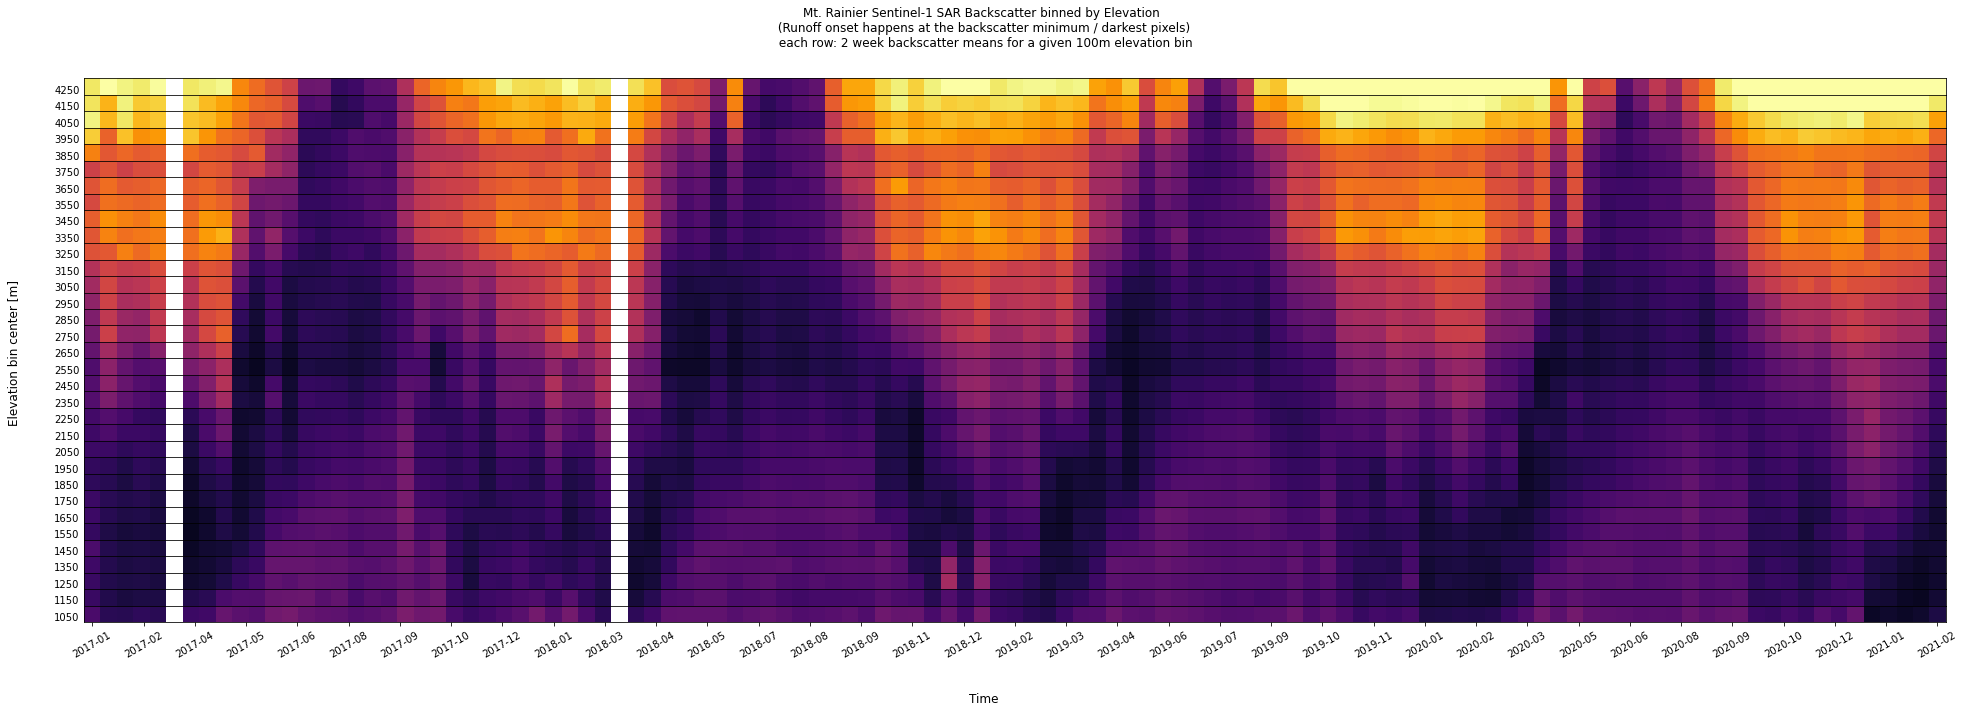

In [37]:
plot_timeseries_by_elevation_bin(frames_elev,dem,bin_size=100)

In [177]:
frames_elev

<xarray.DataArray 'stackstac-7781853c534c6db3ed926857ea02f61d' (time: 113, y: 861, x: 889)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time                         (time) datetime64[ns] 2017-01-08 ... 2021-04-25
    band                         <U9 'gamma0_vv'
  * x                            (x) float64 5.858e+05 5.858e+05 ... 6.036e+05
  * y                            (y) float64 5.2e+06 5.2e+06 ... 5.183e+06
    proj:epsg                    int64 32610
    sar:looks_range              int64 5
    sar:resolution_azimuth       float64 22.6
    mgrs:grid_square             <U2 'ES'
    sar:instrument_mode          <U2 'IW'
    instruments                  <U5 'c-sar'
    sar:pixel_spacing_range      int64 10
    sar:looks_azimuth            int64 1
    constellation                <U10 'sentinel-1'
    sar:center_frequency         float64 5.405
    mgrs:latitude_band           <U1 'T'
    sar:polarizations            object {'VH', 'VV'}
    proj:shape                   object {5490}
    sar:looks_equivalent_number  float64 4.3
    sar:product_type             <U3 'RTC'
    sar:frequency_band           <U1 'C'
    sar:observation_direction    <U5 'right'
    proj:transform               object {0.0, 1.0, -20.0, 499980.0, 5200020.0...
    sar:resolution_range         float64 20.3
    gsd                          int64 20
    sar:pixel_spacing_azimuth    int64 10
    mgrs:utm_zone                <U2 '10'
    sentinel:mgrs                <U5 '10TES'
    title                        <U21 'Gamma0 VV backscatter'
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(499980.0, 5090220.0, 609780.0...
    crs:         epsg:32610
    transform:   | 20.00, 0.00, 499980.00|\n| 0.00,-20.00, 5200020.00|\n| 0.0...
    resolution:  20.0

In [278]:
def plot_timeseries_by_elevation_bin(ts_ds,dem_ds,bin_size=100,ax=None,normalize_bins=False):
    if ax is None:
        ax = plt.gca()
    f = plt.gcf()
    
    dem_projected_ds = dem_ds.rio.reproject_match(ts_ds) # squeeze??
    dem_projected_ds = dem_projected_ds.where(ts_ds!=np.nan) # here mask DEM by ts_ds
    
    bin_centers=list(range(int(math.floor(dem_projected_ds.max()/100)*100)-bin_size//2,int(math.ceil(dem_projected_ds.min()/100)*100),-bin_size))
    backscatter_full = []

    for i,bin_center in enumerate(bin_centers):
        ts_bin_ds = ts_ds.where(np.abs(dem_projected_ds - bin_center) < bin_size//2)
        with warnings.catch_warnings(): #catches np.nanmean empty slices
            warnings.simplefilter("ignore", category=RuntimeWarning)
            backscatter_ts_for_bin = np.nanmean(ts_bin_ds.data.reshape(ts_bin_ds.shape[0],-1), axis=1) 
        backscatter_full.append(list(backscatter_ts_for_bin))
        
    backscatter_df = pd.DataFrame(backscatter_full,index=bin_centers,columns=ts_ds.time)
    
    if normalize_bins == True:
          backscatter_df = ((backscatter_df.T-backscatter_df.T.min())/(backscatter_df.T.max()-backscatter_df.T.min())).T
    
    colors = ax.pcolormesh(pd.to_datetime(ts_ds.time), bin_centers, backscatter_df,cmap='inferno',edgecolors=(1.0, 1.0, 1.0, 0.3)) #,vmin=0,vmax=0.5
    cbar = f.colorbar(colors,ax=ax)
    
    if normalize_bins == False:
        lab = 'Mean Backscatter [Watts]'
    else:
        lab = 'Normalized (Elevation-wise) Backscatter'
    
    cbar.ax.set_ylabel(lab, rotation=270, labelpad=15)

    ax.set_xlabel('Time')
    ax.set_ylabel('Elevation [m]')
    return(ax)

In [284]:
def plot_hyposometry(ts_ds,dem_ds,bin_size=100,ax=None):
    if ax is None:
        ax = plt.gca()
    f = plt.gcf()    
    dem_projected_ds = dem_ds.rio.reproject_match(ts_ds) # squeeze??
    dem_projected_ds = dem_projected_ds.where(ts_ds!=np.nan) # here mask DEM by ts_ds
    bin_centers=list(range(int(math.floor(dem_projected_ds.max()/100)*100)+bin_size,int(math.ceil(dem_projected_ds.min()/100)*100)-bin_size,-bin_size))
    ax.hist(dem_projected_ds.squeeze().isel(time=0).to_numpy().ravel(),bins=bin_centers[::-1],orientation='horizontal')
    ax.set_xlabel('# of Pixels')
    ax.set_ylabel('Elevation [m]')
    ax.set_title('Hyposometry Plot')
    return(ax)

Text(0.5, 0.98, 'Mt. Rainier Sentinel-1 SAR Backscatter binned by Elevation \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each row: 2 week backscatter means for a given 100m elevation bin')

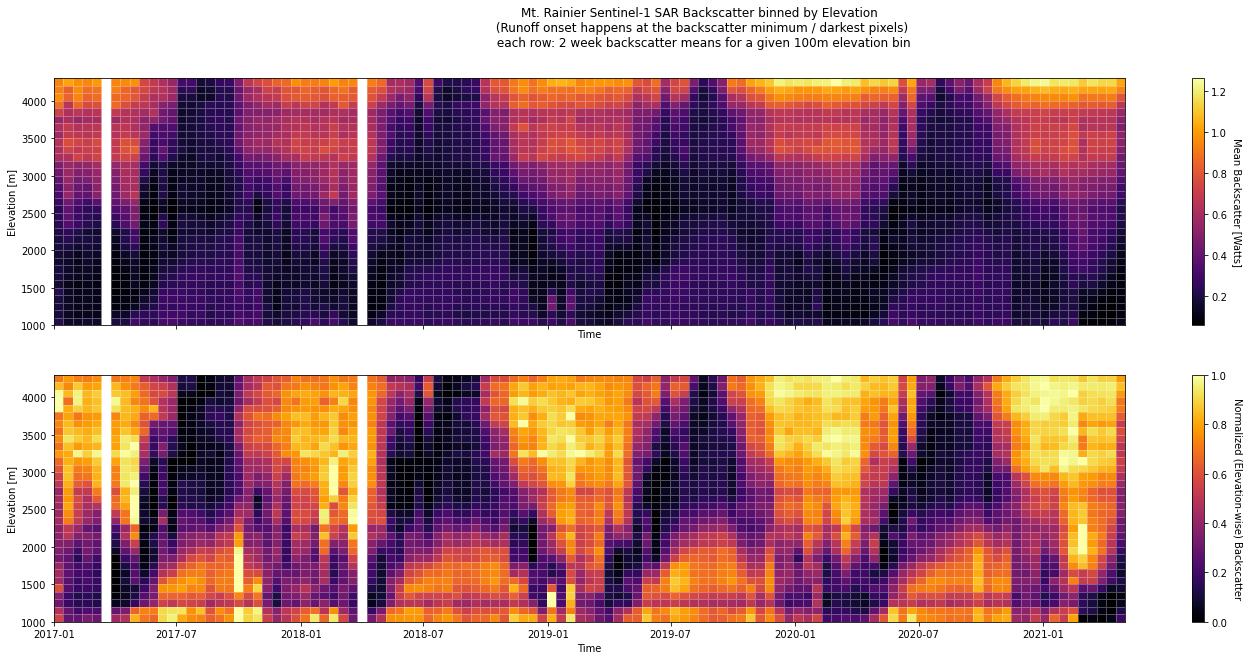

In [280]:
f,ax=plt.subplots(2,1,figsize=(24,10),sharex=True)
plot_timeseries_by_elevation_bin(frames_elev,dem,bin_size=100,ax=ax[0],normalize_bins=False)
plot_timeseries_by_elevation_bin(frames_elev,dem,bin_size=100,ax=ax[1],normalize_bins=True)

f.suptitle("Mt. Rainier Sentinel-1 SAR Backscatter binned by Elevation \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each row: 2 week backscatter means for a given 100m elevation bin")

<AxesSubplot:title={'center':'Hyposometry Plot'}, xlabel='# of Pixels', ylabel='Elevation [m]'>

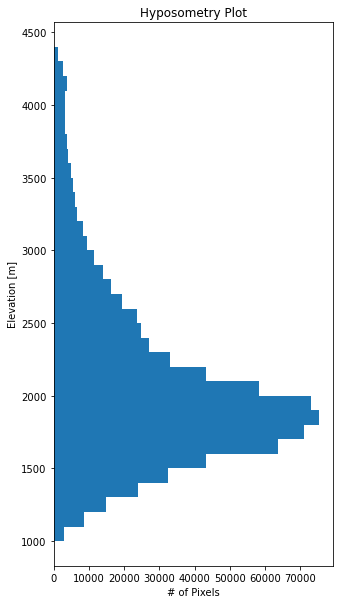

In [286]:
f,ax=plt.subplots(figsize=(5,10))
plot_hyposometry(frames_elev,dem,bin_size=100,ax=ax)